# Initial Experiments w Hierarchical Attention Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a hidden Markov models.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
\end{align*}
$$

where $x_i^{(t)}$ come from a hidden markov model.
$$
\begin{align*}
z_1^{(t)} &\sim \mu, z_{i+1}^{(t)} \sim P(\cdot | z_i^{(t)})\\
x_i^{(t)} &\sim O(\cdot | z_i^{(t)})
\end{align*}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys;sys.path.append('..')
import utils

## Generate Data

In [2]:
num_loops = 4
loop_length = 5 # for now, fixed length
num_notes = 8 # size of observation space

state_transition_edges = []

for l in range(num_loops):
    for s in range(loop_length):
        state_transition_edges.append((f's{l}{s}', f's{l}{(s+1)%loop_length}'))

    # NOTE: this adds connections between loops
    # for l2 in range(num_loops):
    #     state_transition_edges.append((f's{l}0', f's{l2}0'))

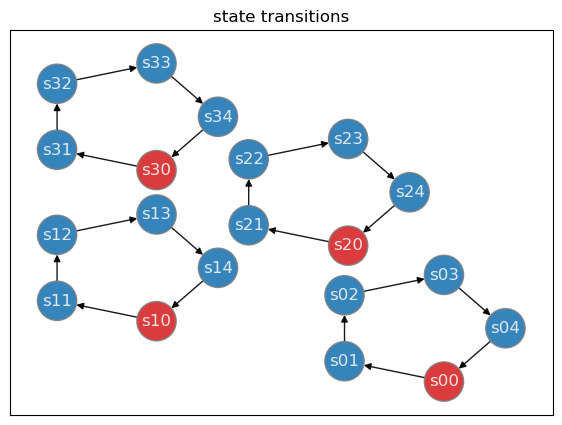

In [3]:
graph = nx.DiGraph(state_transition_edges)

color_map = ['tab:red' if node[-1]=='0' else 'tab:blue' for node in graph.nodes]
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9, "font_color": "whitesmoke"}

fig, ax = plt.subplots(figsize=(7,5))
nx.draw_networkx(graph, with_labels=True, pos=nx.nx_agraph.graphviz_layout(graph, prog='circo'), node_color=color_map, ax=ax, **options)
ax.set_title('state transitions');

In [4]:
states = list(graph.nodes())
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

emissions = [f'o{i}' for i in range(num_notes)]
idx_to_emission = {i: o for i,o in enumerate(emissions)}
emission_to_idx = {o: i for i,o in enumerate(emissions)}

In [5]:
state_transition_matrix = nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense()
state_transition_matrix = state_transition_matrix / np.sum(state_transition_matrix, axis=0)[:, np.newaxis]

In [6]:
emissions_dict = {s: idx_to_emission[np.random.randint(num_notes)] for s in states}
emissions_dict

{'s00': 'o6',
 's01': 'o6',
 's02': 'o3',
 's03': 'o6',
 's04': 'o2',
 's10': 'o1',
 's11': 'o4',
 's12': 'o5',
 's13': 'o6',
 's14': 'o2',
 's20': 'o0',
 's21': 'o4',
 's22': 'o1',
 's23': 'o4',
 's24': 'o0',
 's30': 'o7',
 's31': 'o4',
 's32': 'o7',
 's33': 'o2',
 's34': 'o1'}

In [7]:
emissions_matrix = np.zeros((len(states), num_notes))
for i, s in enumerate(states):
    emissions_matrix[i, emission_to_idx[emissions_dict[s]]] = 1

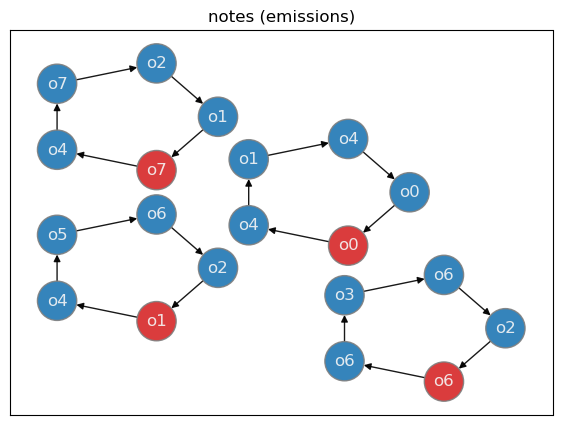

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
nx.draw_networkx(graph, with_labels=True, labels=emissions_dict,
    pos=nx.nx_agraph.graphviz_layout(graph, prog='circo'),
    node_color=color_map, ax=ax, **options)
ax.set_title('notes (emissions)');

In [9]:
def sample_hmm(transition_matrix, emissions_matrix, initial_state, num_steps):
    current_state = initial_state
    states_seq = [current_state]
    emissions_seq = [np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :])]

    for i in range(num_steps-1):
        probabilities = transition_matrix[state_to_idx[current_state], :]
        next_state = np.random.choice(states, p=probabilities)
        states_seq.append(next_state)
        current_state = next_state
        emissions_seq.append(np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :]))
    return states_seq, emissions_seq

In [10]:
mem_seq_len = 5
input_seq_len = 4

mem_seq_initial_states = [f's{l}0' for l in range(num_loops)]
input_seqs_initial_states = [f's{l}0' for l in range(num_loops)]

train_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
train_state_seqs, train_emissions_seqs = train_seqs[:, 0, :], train_seqs[:, 1, :]
train_seqs_x = train_emissions_seqs[:, :-1]
train_seqs_y = train_emissions_seqs[:, 1:]

mem_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, mem_seq_len + 1) for initial_state in mem_seq_initial_states])
mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=len(train_seqs))
mem_state_seqs, mem_emissions_seqs = mem_seqs[:, :, 0, :], mem_seqs[:, :, 1, :]
mem_seqs_x = mem_emissions_seqs[:, :, :-1]
mem_seqs_y = mem_emissions_seqs[:, :, 1:]


In [11]:
print(f'train_seqs_x.shape: {train_seqs_x.shape}; train_seqs_y.shape: {train_seqs_y.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x.shape: {mem_seqs_x.shape}; mem_seqs_y.shape: {mem_seqs_y.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

train_seqs_x.shape: (4, 4); train_seqs_y.shape: (4, 4)
mem_seqs_x.shape: (4, 4, 5); mem_seqs_y.shape: (4, 4, 5)


In [12]:
mem_state_seqs[0]

array([['s00', 's01', 's02', 's03', 's04', 's00'],
       ['s10', 's11', 's12', 's13', 's14', 's10'],
       ['s20', 's21', 's22', 's23', 's24', 's20'],
       ['s30', 's31', 's32', 's33', 's34', 's30']], dtype='<U3')

In [13]:
mem_seqs_x[0]

array([['o6', 'o6', 'o3', 'o6', 'o2'],
       ['o1', 'o4', 'o5', 'o6', 'o2'],
       ['o0', 'o4', 'o1', 'o4', 'o0'],
       ['o7', 'o4', 'o7', 'o2', 'o1']], dtype='<U3')

In [14]:
train_seqs_x

array([['o6', 'o6', 'o3', 'o6'],
       ['o1', 'o4', 'o5', 'o6'],
       ['o0', 'o4', 'o1', 'o4'],
       ['o7', 'o4', 'o7', 'o2']], dtype='<U3')

In [15]:
maptoidx = np.vectorize(lambda x: emission_to_idx[x])
train_seqs_x = maptoidx(train_seqs_x)
train_seqs_y = maptoidx(train_seqs_y)
mem_seqs_x = maptoidx(mem_seqs_x)
mem_seqs_y = maptoidx(mem_seqs_y)

In [16]:
mem_seqs_x

array([[[6, 6, 3, 6, 2],
        [1, 4, 5, 6, 2],
        [0, 4, 1, 4, 0],
        [7, 4, 7, 2, 1]],

       [[6, 6, 3, 6, 2],
        [1, 4, 5, 6, 2],
        [0, 4, 1, 4, 0],
        [7, 4, 7, 2, 1]],

       [[6, 6, 3, 6, 2],
        [1, 4, 5, 6, 2],
        [0, 4, 1, 4, 0],
        [7, 4, 7, 2, 1]],

       [[6, 6, 3, 6, 2],
        [1, 4, 5, 6, 2],
        [0, 4, 1, 4, 0],
        [7, 4, 7, 2, 1]]])

## Hierarchical Attention Model

**Attend within each sequence in memory**

For $t \in [n_m]$,
$$\tilde{m}_i^{(t)} \gets \mathrm{CrossAttn}(Q \gets x_i, K \gets x^{(t)}, V \gets y^{(t)})$$

i.e.,

$$
\begin{align*}
\alpha_{ij}^{(t)} &\gets \mathrm{Softmax}([\langle \phi_Q (x_i), \phi_K (x_j^{(t)}) \rangle]_{j \in [[l]]})\\
\tilde{m}_i^{(t)} &\gets \sum_j \alpha_{ij}^{(t)} \phi_V(y_j^{(t)}) = \sum_{j} \alpha_{ij}^{(t)} \phi_V(x_{j+1}^{(t)})
\end{align*}
$$

**Attend over sequences in memory**
$$\alpha_{it} \gets \mathrm{Softmax}([\max_{j} \langle \phi_Q(x_i), \phi_K(x_j^{(t)}) \rangle]_{t \in [n_m]})$$

($\phi_Q, \phi_K$ can be the same as above.)

**Fetch vector from memory**
$$\tilde{m}_i \gets \sum_t \alpha_{it} \tilde{m}_i^{(t)} = \sum_t \sum_j \alpha_{it} \alpha_{ij}^{(t)} \phi_V(x_{j+1}^{(t)})$$

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from hierarchical_attention import HierarchicalAttention

### Define Memory Model

### without self-attention

In [18]:
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.hierarchical_mem_attention = HierarchicalAttention(
            key_dim, value_dim=embedding_dim, 
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')
        self.output_dense = layers.Dense(vocab_size, name='output')

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [19]:
vocab_size = num_notes
embedding_dim = num_notes

memory_model = MemoryModel(vocab_size, embedding_dim=embedding_dim, key_dim=embedding_dim, name='memory_model')
memory_model([train_seqs_x, mem_seqs_x, mem_seqs_y]); # build model

create_opt = lambda: tf.optimizers.Adam(learning_rate=5e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  64        
                                                                 
 mem_attn (HierarchicalAtten  multiple                 192       
 tion)                                                           
                                                                 
 output (Dense)              multiple                  72        
                                                                 
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________


In [20]:
train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x, mem_seqs_y), train_seqs_y)).batch(4)

In [21]:
history = memory_model.fit(train_ds, epochs=1000, verbose=0)
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [ ]:
memory_model.evaluate(train_ds)

1/1 [==============================] - 0s 291ms/step - loss: 0.9744 - accuracy: 0.5000


[0.974361002445221, 0.5]

### with self-attention

In [ ]:
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        self.hierarchical_mem_attention = HierarchicalAttention(
            key_dim, value_dim=embedding_dim,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')
        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

TODO: check that `self.self_attention` and `self.memory_self_attention` are correctly implemented.

In [ ]:
vocab_size = num_notes
embedding_dim = num_notes

memory_model = MemoryModel(vocab_size, embedding_dim=embedding_dim, key_dim=embedding_dim, name='memory_model')
memory_model([train_seqs_x, mem_seqs_x, mem_seqs_y]); # build model

create_opt = lambda: tf.optimizers.Adam(learning_rate=5e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  64        
                                                                 
 self_attn (MultiHeadAttenti  multiple                 288       
 on)                                                             
                                                                 
 mem_attn (HierarchicalAtten  multiple                 192       
 tion)                                                           
                                                                 
 output (Dense)              multiple                  72        
                                                                 
Total params: 616
Trainable params: 616
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x, mem_seqs_y), train_seqs_y)).batch(4)

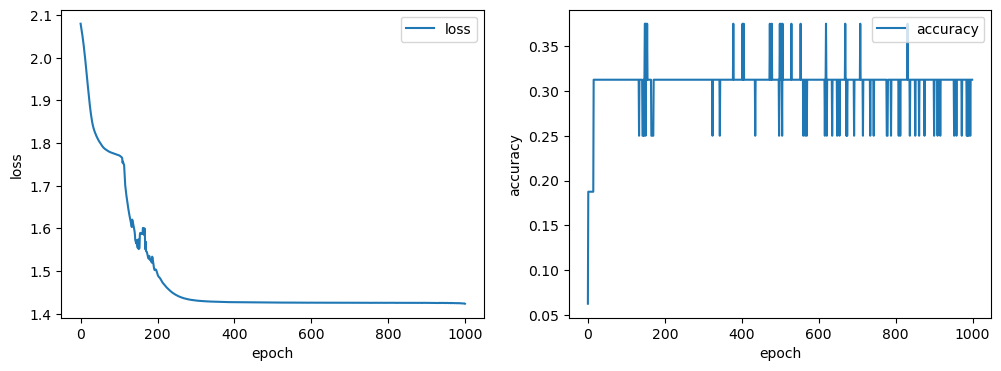

In [ ]:
history = memory_model.fit(train_ds, epochs=1000, verbose=0)
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [ ]:
memory_model.evaluate(train_ds)

1/1 [==============================] - 0s 370ms/step - loss: 1.4236 - accuracy: 0.3125


[1.423629879951477, 0.3125]

### Analyze Hierarchical Attention Mechanism

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_per_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig = plt.figure(figsize=(num_mem_seqs*2,3))
    gs = gridspec.GridSpec(1, num_mem_seqs+1, width_ratios=[0.5]*num_mem_seqs+[0.1])
    axs = [fig.add_subplot(gs[i]) for i in range(num_mem_seqs)]
    cax = fig.add_subplot(gs[-1])
    im = None
    for t, ax in enumerate(axs):
        im = ax.imshow(attn_[t], cmap='gray', vmin=0, vmax=1)
        ax.set_xticks(range(len(mem_seqs_x[t])))
        ax.set_yticks(range(len(train_seqs_x)))
        ax.set_xticklabels(mem_seqs_x[t]);
        ax.set_yticklabels(train_seqs_x);
    fig.colorbar(im, cax=cax)
    axs[0].set_ylabel('input sequence')
    fig.supxlabel('memory sequences', y=0.)
    fig.suptitle('attention within each memory sequence')
    return fig

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    fig, ax = plt.subplots()
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax);
    return fig


#### Example 1: relevant memory exists in buffer (using the same memory buffer as during training)

In [ ]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1]
sample_mem_seq_y = mem_seqs_y[b:b+1]
print(sample_input[0])
print(sample_mem_seq_x[0])

[2 6 7 7]
[[0 7 4 7 6]
 [2 6 7 7 3]
 [1 7 1 3 3]
 [3 2 6 0 4]]


In [ ]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[7 7 7 7]]
[6 7 7 3]
[[False  True  True False]]


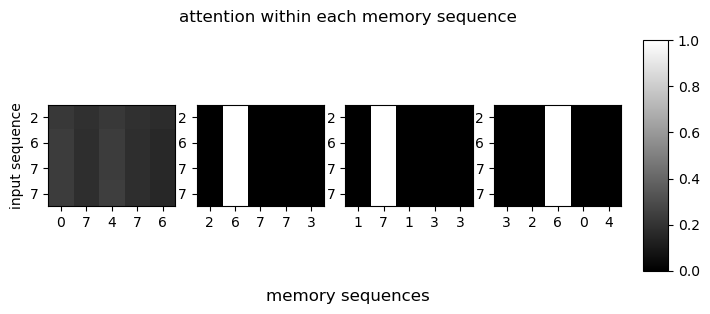

In [ ]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

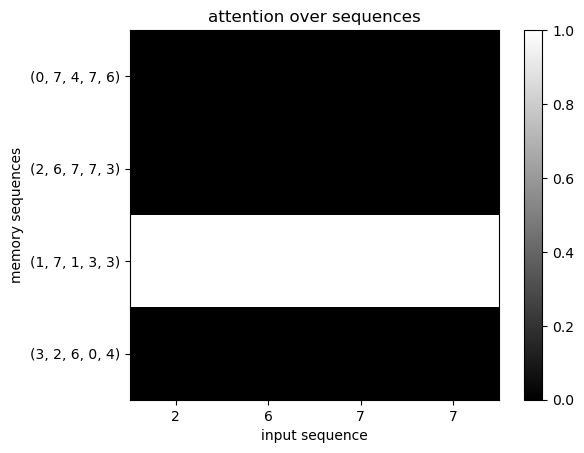

In [ ]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 2: relevant memory exists in buffer (different memory buffer to one used in training)

In [ ]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1, [0, 1, -1]]
sample_mem_seq_y = mem_seqs_y[b:b+1, [0, 1, -1]]
print(sample_input[0])
print(sample_mem_seq_x[0])

[2 6 7 7]
[[0 7 4 7 6]
 [2 6 7 7 3]
 [3 2 6 0 4]]


In [ ]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[6 6 6 6]]
[6 7 7 3]
[[ True False False False]]


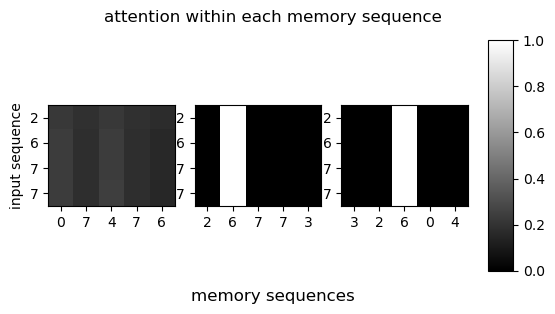

In [ ]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

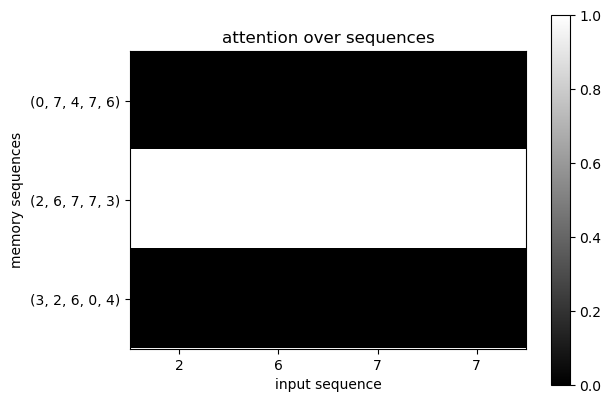

In [ ]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 3: large memory buffer with many irrelevant sequences

In [ ]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
n_reps_ = 5
mem_idxs =  [0] * n_reps_ + [1] + [-2] * n_reps_ + n_reps_ * [-1]
sample_mem_seq_x = mem_seqs_x[b:b+1, mem_idxs]
sample_mem_seq_y = mem_seqs_y[b:b+1, mem_idxs]
print(sample_input[0])
print(sample_mem_seq_x[0])

[2 6 7 7]
[[0 7 4 7 6]
 [0 7 4 7 6]
 [0 7 4 7 6]
 [0 7 4 7 6]
 [0 7 4 7 6]
 [2 6 7 7 3]
 [1 7 1 3 3]
 [1 7 1 3 3]
 [1 7 1 3 3]
 [1 7 1 3 3]
 [1 7 1 3 3]
 [3 2 6 0 4]
 [3 2 6 0 4]
 [3 2 6 0 4]
 [3 2 6 0 4]
 [3 2 6 0 4]]


In [ ]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[7 7 7 7]]
[6 7 7 3]
[[False  True  True False]]


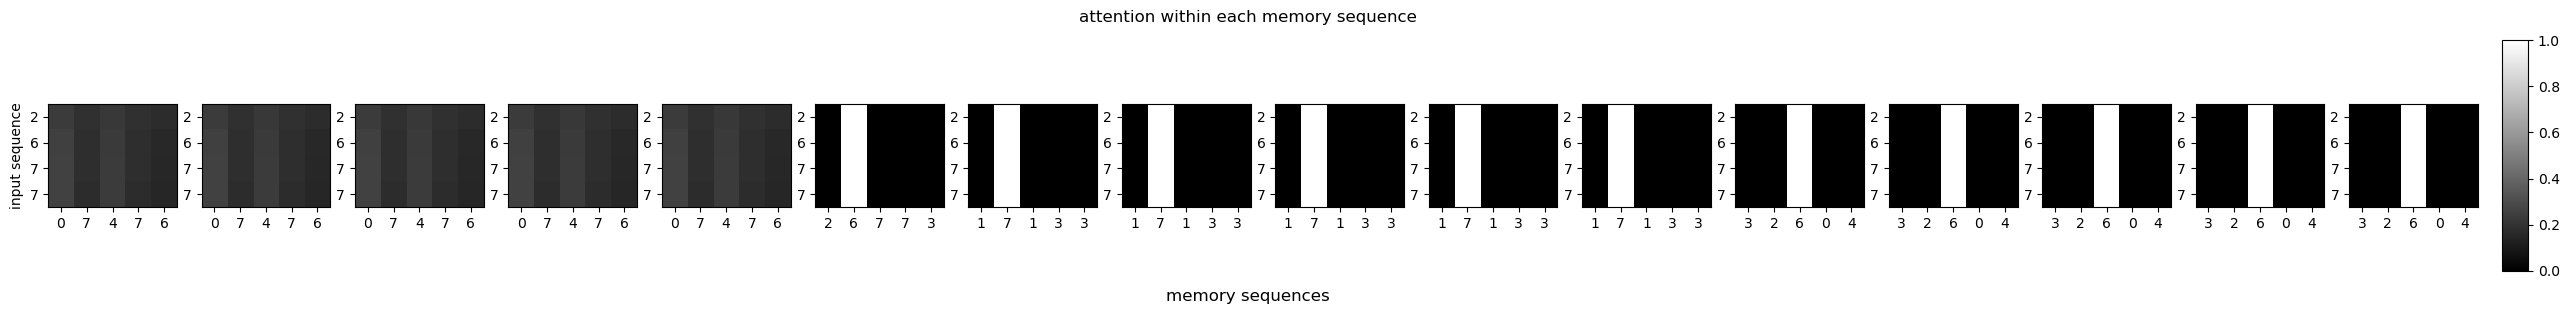

In [ ]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

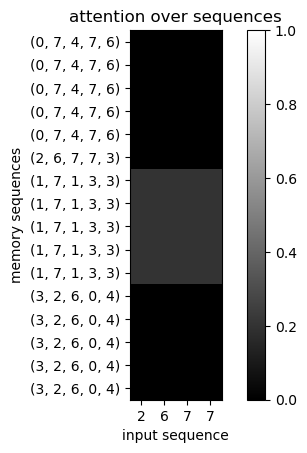

In [ ]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

#### Example 4: relevant memory does not exist in buffer; trained w expectation of relevant memory

The model was trained with the sequence $(1, 2, 3, 4, 1, 2)$ and relevant sequences in the memory buffer (e.g. the sequences $(1, 2, 3, 4)$, $(2, 3, 4, 1)$, etc.). When evaluated on the sequence but with a memory buffer containing only irrelevant information, the model fails.

In [ ]:
# choose sample input
b = 1
sample_input = train_seqs_x[b:b+1]
sample_mem_seq_x = mem_seqs_x[b:b+1, [2, 2, 2]]
sample_mem_seq_y = mem_seqs_y[b:b+1, [2, 2, 2]]
print(sample_input[0])
print(sample_mem_seq_x[0])

[2 6 7 7]
[[1 7 1 3 3]
 [1 7 1 3 3]
 [1 7 1 3 3]]


In [ ]:
pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(pred)
print(train_seqs_y[b])
print(pred == train_seqs_y[b])

[[7 7 7 7]]
[6 7 7 3]
[[False  True  True False]]


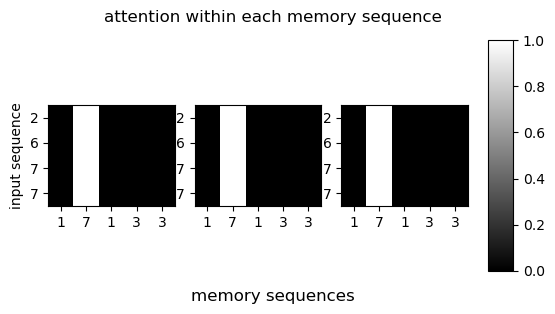

In [ ]:
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

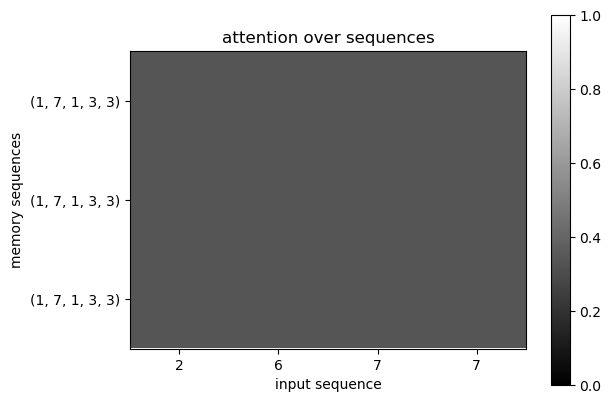

In [ ]:
attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);